In [1]:
%pylab inline

import seaborn as sns

from sigvisa.plotting.event_heatmap import EventHeatmap
from sigvisa.source.event import get_event
from sigvisa import Sigvisa

Populating the interactive namespace from numpy and matplotlib


# Chapter 8 (Evaluation)

## Event locations

In [2]:
train_evids = np.loadtxt("train_evids.txt")
train_evs = [get_event(evid=int(evid)) for evid in train_evids]
train_locs = [(ev.lon, ev.lat) for ev in train_evs]
s = Sigvisa()

stas = "ANMO,ELK,ILAR,KDAK,NEW,NVAR,PDAR,PFO,TXAR,ULM,YBH,YKA".split(",")
sta_locs = np.asarray([s.earthmodel.site_info(sta, 0)[:2] for sta in stas])

stas1 = "ANMO,ELK,NEW,NVAR,PDAR,PFO,TXAR,ULM,YBH,YKA".split(",")
sta1_locs = np.asarray([s.earthmodel.site_info(sta, 0)[:2] for sta in stas1])

stas2 = ["KDAK","ILAR"]
sta2_locs = np.asarray([s.earthmodel.site_info(sta, 0)[:2] for sta in stas2])

ANMO 12 0 2325115.54747 679657.702405
ELK 12 0 1552699.28208 1321639.40904
NEW 12 0 1451591.06202 2161396.78225
NVAR 12 0 1273976.30181 1081794.81776
PDAR 12 0 2027546.39604 1538807.01316
PFO 12 0 1401914.81214 536631.221869
TXAR 12 0 2630497.24685 80136.6851269
ULM 12 0 3000554.11093 2456014.17072
YBH 12 0 940286.576572 1486655.69954
YKA 12 -20 1839150.24706 2589252.0033
KDAK -45 -20 637172.881487 2589252.0033
ILAR -45 -20 1182975.46702 2589252.0033


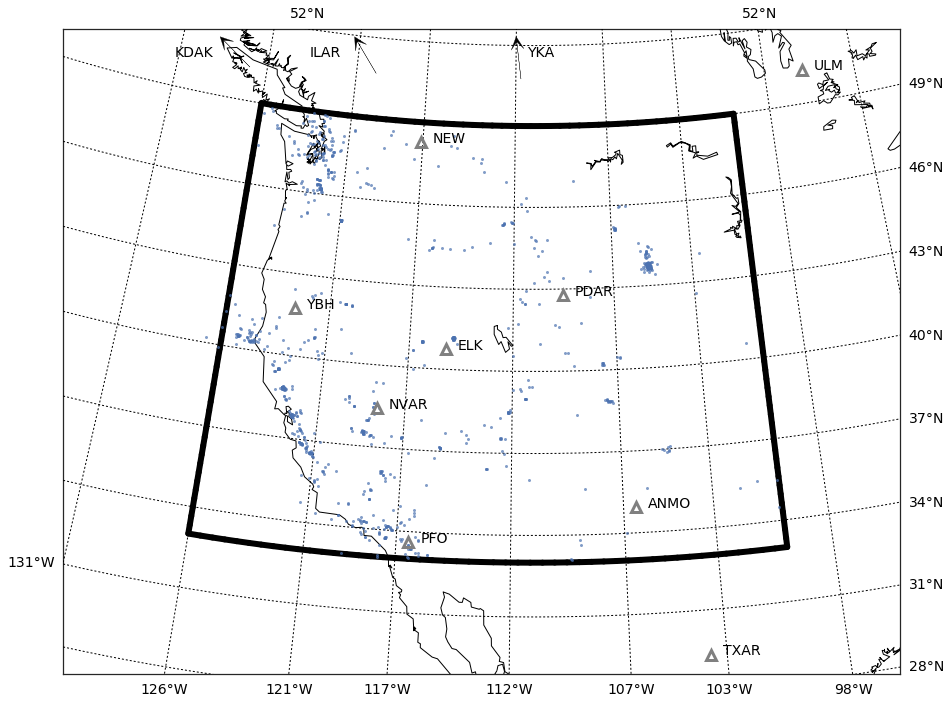

In [6]:
blue, green, red, purple = sns.color_palette()[:4]
sns.set_style("white")

hm = EventHeatmap(f=None, calc=False, left_lon=-130, right_lon=-90, bottom_lat=27, top_lat=51)

f = plt.figure(figsize=(15, 15))
ax = gca()
hm.init_bmap(axes=ax, nofillcontinents=True, projection="aea", lon_0 = -111, lat_0=40)
hm.plot_earth(y_fontsize=14, x_fontsize=14)

normed_locations = np.array([hm.normalize_lonlat(*location[:2]) for location in train_locs ])
#scplot = hm.bmap.scatter(normed_locations[:, 0], normed_locations[:, 1], 
#                         alpha=0.3, s=6, marker=".", color="red")

hm.plot_locations(normed_locations, marker=".", ms=6, mec="none", mew=0,
                    alpha=0.7, color=blue)


hm.plot_locations(sta1_locs, labels=stas1, marker="^", ms=10, mfc="none", mec="gray", mew=3, alpha=1,
                    offmap_arrows=True, arrow_color="black", 
                  label_x_off=12, label_y_off=0, label_pts=14,
                 edge_x_off=-60, edge_y_off=-20)

hm.plot_locations(sta2_locs, labels=stas2, marker="^", ms=10, mfc="none", mec="gray", mew=3, alpha=1,
                    offmap_arrows=True, arrow_color="black", 
                  label_x_off=-45, label_y_off=0, label_pts=14,
                 edge_x_off=-45, edge_y_off=-20)

hm.drawline((-126, 33), (-100, 33), color='black', lw=6, curve_map=True)
hm.drawline((-126, 33), (-126, 49), color='black', lw=6, curve_map=True)
hm.drawline((-126, 49), (-100, 49), color='black', lw=6, curve_map=True)
hm.drawline((-100, 33), (-100, 49), color='black', lw=6, curve_map=True)

## Event clusters

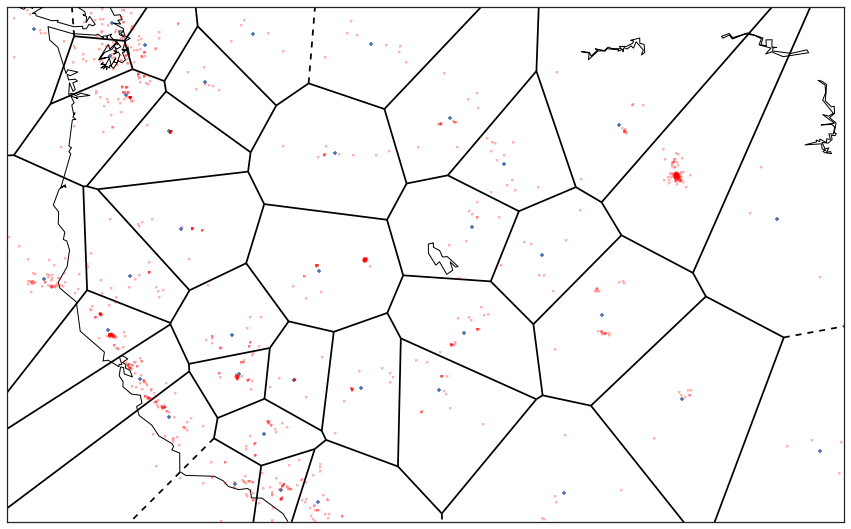

In [13]:
from sigvisa.utils.geog import dist_km
import scipy.spatial


centers = np.loadtxt("/home/dmoore/python/sigvisa/isc_clusters")[:, :2]
vor = scipy.spatial.Voronoi(centers)


def cluster_idx(lon, lat):
    dists = [dist_km((lon, lat), (clon, clat)) for (clon, clat, _) in centers]
    return np.argmin(dists)

s = Sigvisa()
hm = EventHeatmap(f=None, left_lon=-126, right_lon=-100, top_lat=49, bottom_lat=33, calc=True, n=0)

sns.set_style("white")

f = plt.figure(figsize=(15, 15))

ax = plt.gca()

v = scipy.spatial.voronoi_plot_2d(vor, ax=ax, show_vertices=False)
hm.init_bmap(axes=ax, nofillcontinents=True, projection="cyl")

normed_locations = np.array([hm.normalize_lonlat(*location[:2]) for location in train_locs ])
hm.plot_locations(normed_locations, marker=".", ms=6, mec="none", mew=0,
                    alpha=0.3, color="red")





## Event prior

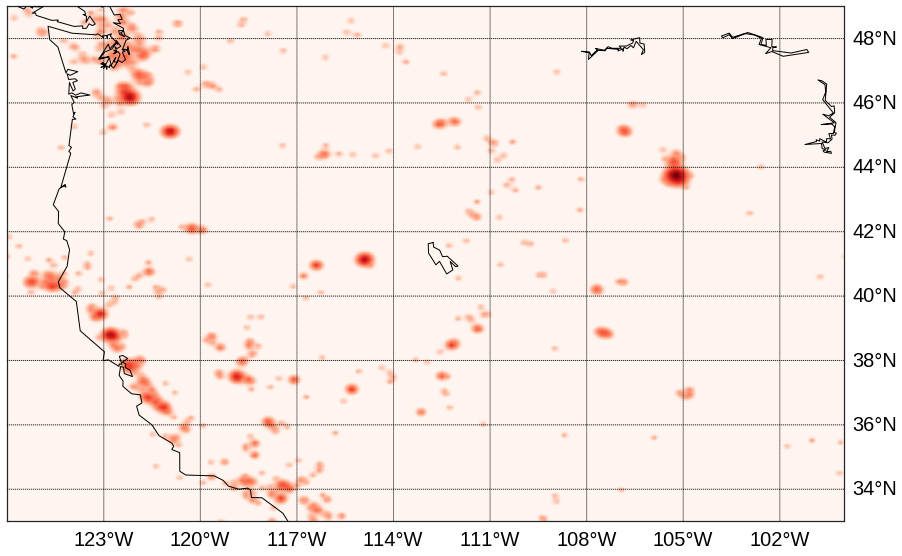

In [14]:
def prior_lp(lon, lat):
    lp = s.sigmodel.event_location_prior_logprob(lon, lat, -1)
    #if lp < -20:
    #    lp = s.sigmodel.event_location_prior_logprob(-101, 48, -1)
    return lp

def prior_prob(lon, lat):
    return np.exp(prior_lp(lon, lat))

s = Sigvisa()
hm = EventHeatmap(f=prior_lp, left_lon=-126, right_lon=-100, top_lat=49, bottom_lat=33, calc=True, n=500)

f = plt.figure(figsize=(15, 15))
ax = plt.gca()
hm.init_bmap(axes=ax, nofillcontinents=True, projection="cyl")
hm.plot_earth(y_fontsize=20, x_fontsize=20)

cm = matplotlib.cm.get_cmap('Reds')
hm.plot_density(smooth=True, cm=cm, colorbar=False, vmin=-1.0, zorder=-5)


In [15]:
# compute dynamic range
minlp = np.min(hm.fvals[hm.fvals > -40])
maxlp = np.max(hm.fvals)
print minlp, maxlp
print "dynamic range", maxlp - minlp

-6.37067948378 5.02126728263
dynamic range 11.3919467664


## Event score distribution

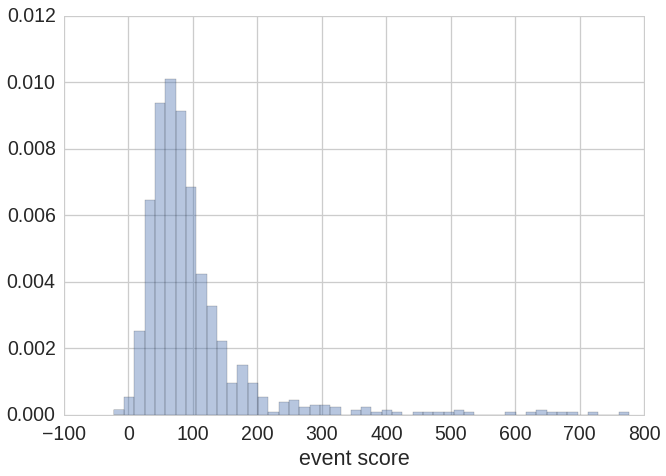

In [16]:
from sigvisa.graph.serialization import load_serialized_from_file

evdicts, uadicts_by_sta = load_serialized_from_file("/home/dmoore/python/sigvisa/cloud/remote_jobs/test_omg_seed2/merged.tgz")
scores = [evd["score"] for evd in evdicts]

sns.set_context("talk", font_scale=1.5)
sns.set_style("whitegrid")
f = plt.figure()
ax = gca()
sns.distplot(scores, kde=False, norm_hist=True)
ax.set_xlabel("event score")
#ax.set_ylim([0, 170])


## De novo events

/home/dmoore/.virtualenvs/sigvisa/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


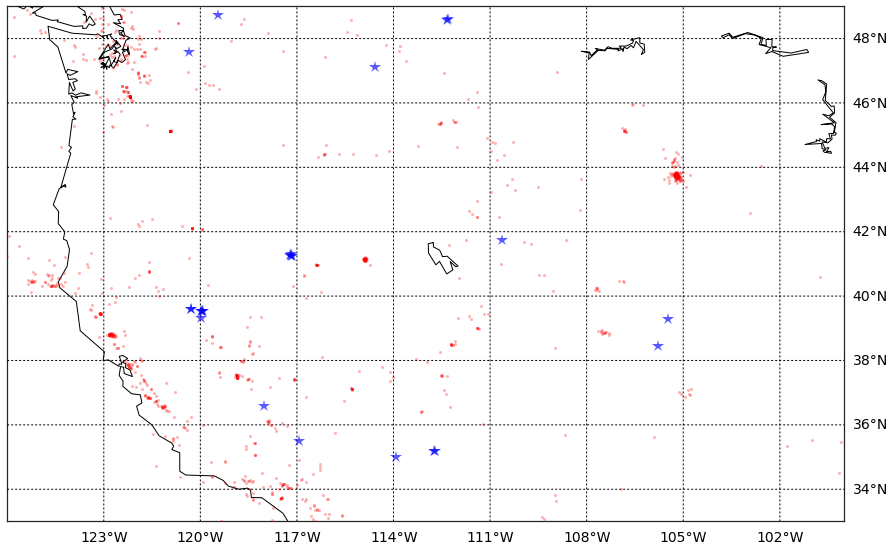

In [3]:
denovo_evids = np.loadtxt("/home/dmoore/python/sigvisa/notebooks/thesis/denovo_evids.txt")
denovo_evs = [get_event(evid=evid) for evid in denovo_evids]
denovo_locs = [(ev.lon, ev.lat) for ev in denovo_evs]

s = Sigvisa()
hm = EventHeatmap(f=None, left_lon=-126, right_lon=-100, top_lat=49, bottom_lat=33, calc=True, n=0)

sns.set_style("white")

f = plt.figure(figsize=(15, 15))
ax = plt.gca()
hm.init_bmap(axes=ax, nofillcontinents=True, projection="cyl")
hm.plot_earth(y_fontsize=14, x_fontsize=14)

normed_locations = np.array([hm.normalize_lonlat(*location[:2]) for location in train_locs ])
hm.plot_locations(normed_locations, marker=".", ms=6, mec="none", mew=0,
                    alpha=0.3, color="red")

normed_locations = np.array([hm.normalize_lonlat(*location[:2]) for location in denovo_locs ])
hm.plot_locations(normed_locations, marker="*", ms=12, mec="blue", mew=0,
                    alpha=0.65, color="blue")





# Test bulletin

In [4]:
import os
import numpy as np

basedir = "/home/dmoore/python/sigvisa/notebooks/thesis/results/"

isc_bulletin = np.loadtxt(os.path.join(basedir, "isc_bulletin_visa.txt"))
isc_wells_bulletin = np.loadtxt(os.path.join(basedir, "merged_origins.txt"))
isc_wells_mb_bulletin = np.loadtxt(os.path.join(basedir, "merged_origins_mbcorrected.txt"))

isc_wells_analyst_bulletin = np.loadtxt(os.path.join(basedir, "merged_analyst.txt"))

def present(bulletin, ev):
    for ev2 in bulletin:
        if np.max(np.abs(ev2[:5] - ev[:5])) < 0.1:
            return True
    return False

isc_wells_new = np.array([ev for ev in isc_wells_bulletin if not present(isc_bulletin, ev)])



ANMO -10 -18 -106.4567 34.9462
ELK -10 -18 -115.2388 40.7448
ILAR -10 -20 -119.548533322 49.0
KDAK -10 -20 -125.029432439 49.0
NEW -10 -18 -117.12 48.26333
NVAR -10 -18 -118.30355 38.429609
PDAR -10 -18 -109.5579 42.7667
PFO -10 -18 -116.4553 33.6092
TXAR -10 -18 -106.266207748 33.0
ULM -20 -18 -100.0 48.5167289879
YBH -10 -18 -122.71038 41.73193
YKA -10 -20 -113.429164961 49.0


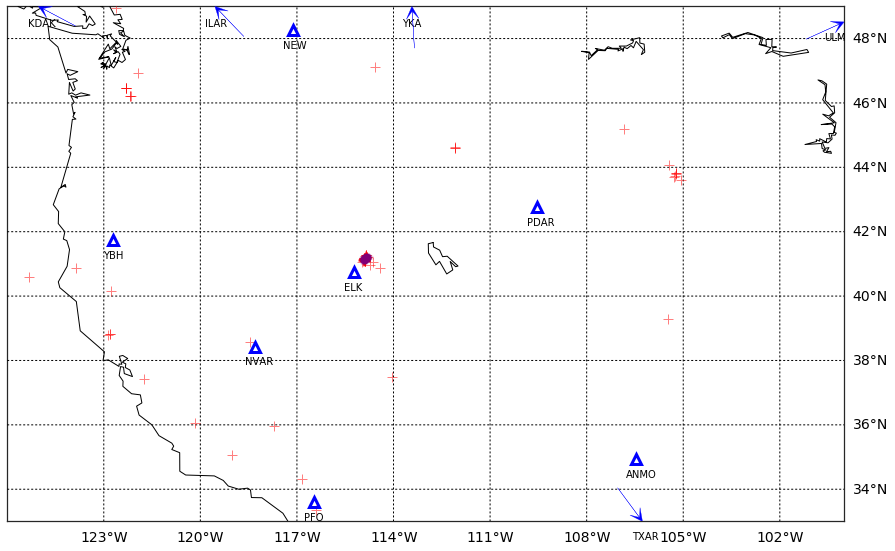

In [5]:

s = Sigvisa()
hm = EventHeatmap(f=None, left_lon=-126, right_lon=-100, top_lat=49, bottom_lat=33, calc=True, n=0)

sns.set_style("white")

f = plt.figure(figsize=(15, 15))
ax = plt.gca()
hm.init_bmap(axes=ax, nofillcontinents=True, projection="cyl")
hm.plot_earth(y_fontsize=14, x_fontsize=14)


normed_locations = np.array([hm.normalize_lonlat(*location[:2]) for location in isc_bulletin ])
hm.plot_locations(normed_locations, marker="+", ms=10, mec="red", mew=1,
                    alpha=0.5, color="red")

normed_locations = np.array([hm.normalize_lonlat(*location[:2]) for location in isc_wells_new ])
hm.plot_locations(normed_locations, marker=".", ms=10, mec="none", mew=0,
                    alpha=0.1, color="purple")



stas = "ANMO,ELK,ILAR,KDAK,NEW,NVAR,PDAR,PFO,TXAR,ULM,YBH,YKA".split(",")
sta_locations = [s.earthmodel.site_info(n, 0)[0:2] for n in stas]
hm.plot_locations(sta_locations, labels=stas, offmap_arrows=True,
                  marker="^", ms=10, mec="blue", mew=3,
                  alpha=1.0, mfc="none", arrow_color="blue", 
                  label_x_off=-10, label_y_off=-18, label_pts=10,)
    


#normed_locations = np.array([hm.normalize_lonlat(*location[:2]) for location in denovo_locs ])
#hm.plot_locations(normed_locations, marker="*", ms=12, mec="blue", mew=0,
#                    alpha=0.65, color="blue")

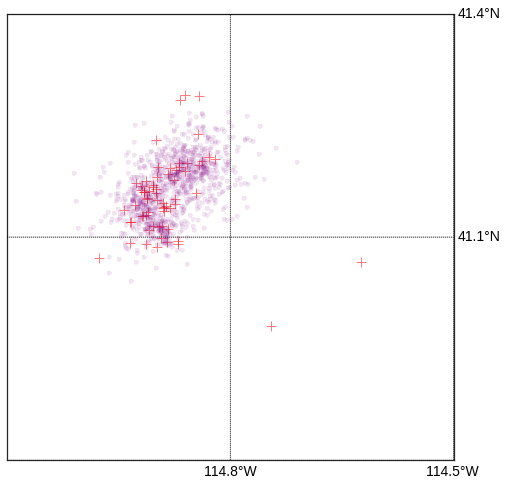

In [20]:
s = Sigvisa()
hm = EventHeatmap(f=None, left_lon=-115.1, right_lon=-114.5, top_lat=41.4, bottom_lat=40.8, calc=True, n=0)

sns.set_style("white")

f = plt.figure(figsize=(8, 8))
ax = plt.gca()
hm.init_bmap(axes=ax, nofillcontinents=True, projection="cyl")
hm.plot_earth(y_fontsize=14, x_fontsize=14, interval=0.3)

normed_locations = np.array([hm.normalize_lonlat(*location[:2]) for location in isc_bulletin ])
hm.plot_locations(normed_locations, marker="+", ms=10, mec="red", mew=1,
                    alpha=0.5, color="red")

normed_locations = np.array([hm.normalize_lonlat(*location[:2]) for location in isc_wells_new ])
hm.plot_locations(normed_locations, marker=".", ms=10, mec="none", mew=0,
                    alpha=0.1, color="purple")

# Evaluation curves and plots

In [6]:
import os
import numpy as np

basedir = "/home/dmoore/python/sigvisa/notebooks/thesis/results/"

netvisa_bulletin = np.loadtxt(os.path.join(basedir, "visa_bulletin_visa.txt"))
sel3_bulletin = np.loadtxt(os.path.join(basedir, "sel3_bulletin_sel3.txt"))
leb_bulletin = np.loadtxt(os.path.join(basedir, "leb_bulletin_leb.txt"))

sigvisa_bulletin_merged_123 = np.loadtxt(os.path.join(basedir, "sigvisa_bulletin_seed123_sum.txt"))
sigvisa_bulletin_merged_123hf = np.loadtxt(os.path.join(basedir, "sigvisa_bulletin_test123_12.txt"))
sigvisa_bulletin_seed1 = np.loadtxt(os.path.join(basedir, "sigvisa_bulletin_test_omg_seed1.txt"))
sigvisa_bulletin_seed2 = np.loadtxt(os.path.join(basedir, "sigvisa_bulletin_test_omg_seed2.txt"))
sigvisa_bulletin_seed3 = np.loadtxt(os.path.join(basedir, "sigvisa_bulletin_test_omg_seed3.txt"))

sigvisa_bulletin_hf11 = np.loadtxt(os.path.join(basedir, "sigvisa_bulletin_test_highfreq_seed11.txt"))
sigvisa_bulletin_hf12 = np.loadtxt(os.path.join(basedir, "sigvisa_bulletin_test_highfreq_seed12.txt"))


isc_bulletin = np.loadtxt(os.path.join(basedir, "isc_bulletin_visa.txt"))
isc_wells_mb_bulletin = np.loadtxt(os.path.join(basedir, "merged_origins_mbcorrected.txt"))
isc_wellslarge_bulletin = np.loadtxt(os.path.join(basedir, "merged_origins_large.txt"))
isc_wells_bulletin = np.loadtxt(os.path.join(basedir, "merged_origins.txt"))

isc_wells_analyst_bulletin = np.loadtxt(os.path.join(basedir, "merged_analyst.txt"))


truth = isc_wells_bulletin


In [7]:
from sigvisa.results.compare import f1_and_error

kwargs = {
    'max_delta_deg': 2.0,
    'max_delta_time': 50.0
}

# threshold to match precision of SEL3
sigvisa_thresholded = np.asarray([ev for ev in sigvisa_bulletin_merged_123hf if ev[5] > 160])
print len(sigvisa_thresholded)
_, thresholded_precision, thresholded_recall, _, _ = f1_and_error(truth, sigvisa_thresholded, **kwargs)
print "precision", thresholded_precision, "recall", thresholded_recall



393
precision 51.3994910941 recall 19.3116634799


In [8]:
_, netvisa_prec, netvisa_recall, netvisa_meanerr, netvisa_errors = f1_and_error(truth, netvisa_bulletin, **kwargs)

print netvisa_prec, netvisa_recall
print leb_precision, leb_recall

54.6762589928 7.26577437859


NameError: name 'leb_precision' is not defined

# LEB events not in ISC

In [29]:
from sigvisa.results.compare import find_matching

indices = find_matching(isc_bulletin, leb_bulletin, **kwargs)
unmatched_events = set(np.arange(len(leb_bulletin))) - set([j for (i,j) in  indices])
print unmatched_events

set([1, 4, 10, 12, 13, 14, 15, 19, 27, 28, 30, 31, 38, 39, 45, 46, 49, 51, 52, 54, 55, 56, 57, 58, 62, 63, 66, 69, 72, 77, 83, 84, 85, 86, 87, 92, 93])


In [31]:
print indices
print isc_bulletin[3,:]
print leb_bulletin[3,:]

[(0, 0), (1, 2), (3, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (10, 11), (11, 16), (12, 17), (14, 18), (15, 20), (16, 21), (17, 22), (19, 23), (21, 24), (23, 25), (24, 26), (25, 29), (26, 32), (27, 33), (28, 34), (30, 35), (31, 36), (32, 37), (35, 40), (37, 41), (38, 42), (39, 43), (40, 44), (41, 47), (42, 48), (43, 50), (44, 53), (53, 59), (55, 60), (56, 61), (63, 64), (64, 65), (67, 67), (68, 68), (70, 70), (71, 71), (73, 73), (75, 74), (76, 75), (77, 76), (78, 78), (79, 79), (80, 80), (82, 81), (85, 82), (88, 88), (89, 89), (90, 90), (96, 91), (100, 94), (101, 95)]
[ -1.14900300e+02   4.11590000e+01   1.00000000e+01   1.20365684e+09
   3.20000000e+00   0.00000000e+00   3.37534700e+06]
[ -1.14921590e+02   4.11992080e+01   0.00000000e+00   1.20365684e+09
   3.18826590e+00   0.00000000e+00   4.61653900e+06]


In [18]:
print "unmatched leb events:"
print leb_bulletin[19,:]
print leb_bulletin[83,:]


unmatched leb events
[ -1.14883450e+02   4.11050590e+01   0.00000000e+00   1.20367808e+09
  -9.99000000e+02   0.00000000e+00   4.61942700e+06]
[ -1.14924310e+02   4.12255310e+01   0.00000000e+00   1.20438034e+09
  -9.99000000e+02   0.00000000e+00   4.62866400e+06]


# Merged ISC/Wells prec/recall

In [9]:
from sigvisa.results.evaluate_serialized import precision_recall_curve
from sigvisa.results.compare import f1_and_error

kwargs = {
    'max_delta_deg': 2.0,
    'max_delta_time': 50.0
}
freq=15

netvisa_precs, netvisa_recalls = precision_recall_curve(netvisa_bulletin, truth, 
                                                        freq=freq, cheap=True, **kwargs)
_, _, _, netvisa_meanerr, netvisa_errors = f1_and_error(truth, netvisa_bulletin, **kwargs)


sigvisa_precs, sigvisa_recalls = precision_recall_curve(sigvisa_bulletin_merged_123, truth, 
                                                        freq=freq, cheap=True, **kwargs)
_, _, _, sigvisa_meanerr, sigvisa_errors = f1_and_error(truth, sigvisa_bulletin_merged_123, **kwargs)

sigvisa_withhf_precs, sigvisa_withhf_recalls = precision_recall_curve(sigvisa_bulletin_merged_123hf, truth, 
                                                                      freq=freq, cheap=True, **kwargs)
_, _, _, sigvisa_withhf_meanerr, sigvisa_withhf_errors = f1_and_error(truth, sigvisa_bulletin_merged_123hf, **kwargs)

sigvisa_seed1_precs, sigvisa_seed1_recalls = precision_recall_curve(sigvisa_bulletin_seed1, truth, 
                                                                    freq=freq, cheap=True, **kwargs)
_, _, _, sigvisa_seed1_meanerr, sigvisa_seed1_errors = f1_and_error(truth, sigvisa_bulletin_seed1, **kwargs)

sigvisa_seed2_precs, sigvisa_seed2_recalls = precision_recall_curve(sigvisa_bulletin_seed2, truth, 
                                                                    freq=freq, cheap=True, **kwargs)
_, _, _, sigvisa_seed2_meanerr, sigvisa_seed2_errors = f1_and_error(truth, sigvisa_bulletin_seed1, **kwargs)

sigvisa_seed3_precs, sigvisa_seed3_recalls = precision_recall_curve(sigvisa_bulletin_seed3, truth,
                                                                    freq=freq, cheap=True, **kwargs)
_, _, _, sigvisa_seed3_meanerr, sigvisa_seed3_errors = f1_and_error(truth, sigvisa_bulletin_seed1, **kwargs)


sigvisa_hf11_precs, sigvisa_hf11_recalls = precision_recall_curve(sigvisa_bulletin_hf11, truth,
                                                                    freq=freq, cheap=True, **kwargs)
_, _, _, sigvisa_hf11_meanerr, sigvisa_hf11_errors = f1_and_error(truth, sigvisa_bulletin_hf11, **kwargs)

sigvisa_hf12_precs, sigvisa_hf12_recalls = precision_recall_curve(sigvisa_bulletin_hf12, truth,
                                                                    freq=freq, cheap=True, **kwargs)
_, _, _, sigvisa_hf12_meanerr, sigvisa_hf12_errors = f1_and_error(truth, sigvisa_bulletin_hf12, **kwargs)

_, leb_precision, leb_recall, leb_meanerr, leb_errors = f1_and_error(truth, leb_bulletin, **kwargs)
_, sel3_precision, sel3_recall, sel3_meanerr, sel3_errors = f1_and_error(truth, sel3_bulletin, **kwargs)

/home/dmoore/python/sigvisa/treegp/gpy_linalg.py:39: UserWarning: warning: caught this exception:'module' object has no attribute '_dotblas'
  warnings.warn("warning: caught this exception:" + str(e))


0 events threshold 176.7 precision 100.0 recall 0.1
15 events threshold 41.0 precision 87.5 recall 1.3
30 events threshold 33.1 precision 83.9 recall 2.5
45 events threshold 25.6 precision 73.9 recall 3.3
60 events threshold 20.8 precision 73.8 recall 4.3
75 events threshold 17.4 precision 73.7 recall 5.4
90 events threshold 13.6 precision 72.5 recall 6.3
105 events threshold 10.2 precision 66.0 recall 6.7
120 events threshold 6.9 precision 61.2 recall 7.1
135 events threshold 3.6 precision 55.1 recall 7.2
0 events threshold 2253.6 precision 100.0 recall 0.1
15 events threshold 1058.3 precision 100.0 recall 1.5
30 events threshold 841.8 precision 93.5 recall 2.8
45 events threshold 629.5 precision 82.6 recall 3.6
60 events threshold 545.0 precision 83.6 recall 4.9
75 events threshold 479.1 precision 85.5 recall 6.2
90 events threshold 444.3 precision 85.7 recall 7.5
105 events threshold 395.4 precision 82.1 recall 8.3
120 events threshold 364.7 precision 79.3 recall 9.2
135 events thre

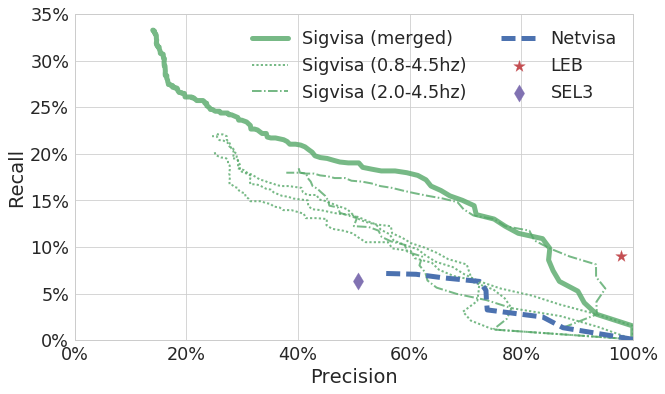

In [13]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.ticker as mtick

import seaborn as sns

blue, green, red, purple = sns.color_palette()[:4]

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2.2)
fig = plt.figure(figsize=(10, 6))
axes = fig.add_subplot(111)


axes.plot(sigvisa_withhf_precs, sigvisa_withhf_recalls, label="Sigvisa (merged)", 
          color=green, alpha=0.8, ls='-', lw=5)

#axes.plot(sigvisa_precs, sigvisa_recalls, label="Sigvisa (merged)", color=green, alpha=1.0, lw=3, ls='-')


axes.plot(sigvisa_seed1_precs, sigvisa_seed1_recalls, color=green, label="Sigvisa (0.8-4.5hz)", alpha=0.8, ls=':', lw=2)
axes.plot(sigvisa_seed2_precs, sigvisa_seed2_recalls, color=green, alpha=0.8, ls=':', lw=2)
axes.plot(sigvisa_seed3_precs, sigvisa_seed3_recalls, color=green, alpha=0.8, ls=':', lw=2)

axes.plot(sigvisa_hf11_precs, sigvisa_hf11_recalls, color=green, label="Sigvisa (2.0-4.5hz)", alpha=0.8, ls='-.', lw=2)
sigvisa_hf12_precs_hack, sigvisa_hf12_recalls_hack = zip(*[(p, r) for (p, r) in zip(sigvisa_hf12_precs, sigvisa_hf12_recalls) if p > 0])
axes.plot(sigvisa_hf12_precs_hack, sigvisa_hf12_recalls_hack, color=green, alpha=0.8, ls='-.', lw=2)


axes.plot(netvisa_precs, netvisa_recalls, label="Netvisa", color=blue, lw=5, ls='--')


#axes.scatter(thresh_precision, thresh_recall, marker="^", s=100, color="orange", label="Sigvisa (125)")
axes.scatter(leb_precision, leb_recall, marker="*", s=150, color=red, label="LEB")
axes.scatter(sel3_precision, sel3_recall, marker="d", s=150, color=purple, label="SEL3")

axes.set_xlabel("Precision")
axes.set_ylabel("Recall")
axes.set_xlim((0, 100))
axes.set_ylim((0, 35))


axes.legend(loc="upper right", ncol=2)


fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
axes.yaxis.set_major_formatter(yticks)
_ = axes.xaxis.set_major_formatter(yticks)


In [28]:
print sigvisa_withhf_precs

[100.0, 100.0, 93.54838709677419, 91.30434782608695, 90.1639344262295, 86.84210526315789, 85.71428571428571, 84.90566037735849, 85.12396694214875, 83.82352941176471, 79.47019867549669, 77.10843373493977, 75.13812154696133, 71.93877551020408, 71.56398104265404, 69.46902654867256, 67.21991701244814, 65.625, 63.837638376383765, 62.93706293706294, 61.461794019933556, 59.49367088607595, 57.40181268882175, 54.91329479768786, 53.18559556786703, 51.59574468085106, 50.89514066496164, 49.01477832512315, 47.50593824228029, 46.330275229357795, 45.23281596452328, 43.99141630901288, 43.03534303534303, 42.54032258064516, 41.87866927592955, 41.254752851711025, 40.48059149722736, 39.568345323741006, 38.52889667250438, 38.05460750853242, 37.437603993344425, 36.688311688311686, 35.97464342313788, 35.139318885448915, 34.49319213313162, 34.319526627218934, 33.57452966714906, 33.14447592067989, 32.73231622746186, 32.20108695652174, 31.55792276964048, 31.4621409921671, 31.11395646606914, 30.77889447236181, 3

## Sigvisa variants prec/recall

## All methods prec/recall

## Location errors

In [10]:
import seaborn as sns

import pandas as pd

basedir = "/home/dmoore/python/sigvisa/notebooks/thesis/results/"
errs = {}
errs["Netvisa"] = netvisa_errors
errs["LEB"] = leb_errors
errs["SEL3"] = sel3_errors
errs["Sigvisa"] = sigvisa_withhf_errors

max_len = np.max([len(x) for x in errs.values()])
padded = {k : np.concatenate((errs[k], np.ones(max_len - len(errs[k]))*np.nan )) for k in errs.keys()}

d = pd.DataFrame(padded)

(0, 100)

(0, 100)

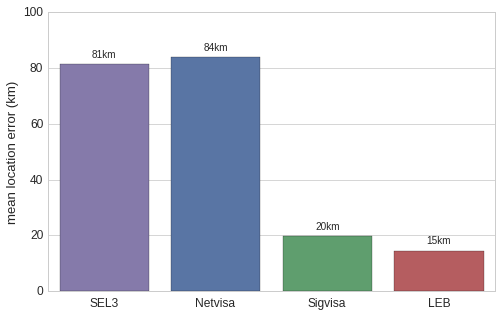

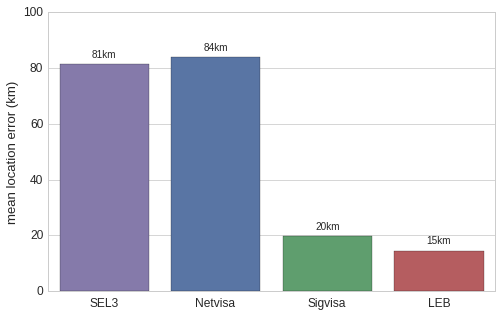

In [11]:
fig = plt.figure(figsize=(8, 5))
axes = fig.add_subplot(111)
order=["SEL3", "Netvisa", "Sigvisa", "LEB"]

# permute colors to match above precision-recall plot
palette = sns.color_palette()
permuted = (palette[3], palette[0], palette[1], palette[2])

sns.barplot(data=d, order=order, axes=axes, palette=permuted, ci=None)

# label the plot with error values
rects = axes.patches
labels = ["%.0fkm" % np.mean(errs[key]) for key in order]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axes.text(rect.get_x() + rect.get_width()/2, height + 2, label, ha='center', va='bottom')

axes.set_ylabel("mean location error (km)")
axes.set_ylim([0, 100])

(0, 250)

(0, 250)

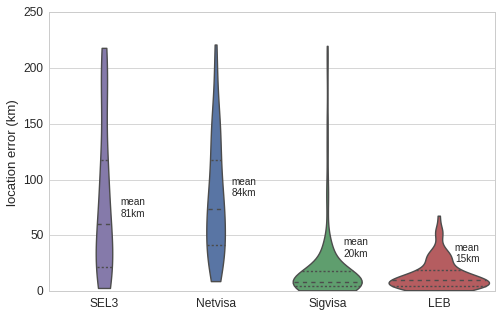

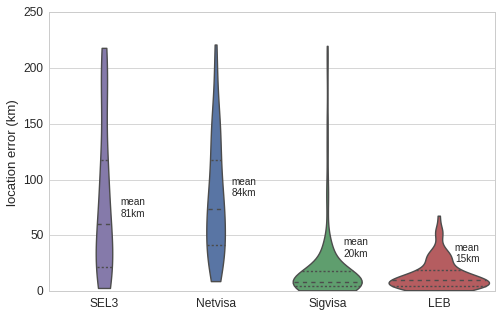

In [12]:
fig = plt.figure(figsize=(8, 5))
axes = fig.add_subplot(111)
order = ["SEL3", "Netvisa", "Sigvisa", "LEB"]

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

# permute colors to match above precision-recall plot
palette = sns.color_palette()
permuted = (palette[3], palette[0], palette[1], palette[2])

sns.set_context("paper", font_scale=1.5)
sns.violinplot(data=d, order=order, palette=permuted, axes=axes, inner="quartile", width=0.9, cut=0)
axes.set_ylabel("location error (km)")

# label the plot with error values
rects = axes.patches
labels = ["%.0fkm" % np.mean(errs[key]) for key in order]
heights = [66, 84, 30, 25]
for i, key in enumerate(order):
    v = np.mean(errs[key])
    m = np.max(errs[key])
    #height = rect.get_height()
    axes.text(i + 0.25, heights[i], "mean\n%.0fkm" % v, ha='center', va='bottom')

axes.set_ylim([0, 250])

# De Novo events


In [4]:
from sigvisa.utils.geog import dist_km
import os

basedir = "/home/dmoore/python/sigvisa/notebooks/thesis/results/"

# python results/evaluate_serialized.py  --serialized=cloud/remote_jobs/dn1234/merged.tgz --denovo

sigvisa_denovo_bulletin = np.loadtxt(os.path.join(basedir, "sigvisa_bulletin_dn1234.txt"))
leb_denovo_bulletin = np.loadtxt(os.path.join(basedir, "leb_bulletin_dn1234.txt"))
sel3_denovo_bulletin = np.loadtxt(os.path.join(basedir, "sel3_bulletin_dn1234.txt"))
visa_denovo_bulletin = np.loadtxt(os.path.join(basedir, "visa_bulletin_dn1234.txt"))


sigvisa_denovo_thresholded_bulletin = np.asarray([ev for ev in sigvisa_denovo_bulletin if ev[5] > 128.0])

def filter_de_novo(bulletin):
    train_evids = [int(evid) for evid in np.loadtxt("/home/dmoore/python/sigvisa/notebooks/thesis/train_evids.txt")]
    train_evs = [get_event(evid) for evid in train_evids]

    def is_denovo(row, dist_threshold_km=50):
        lon, lat, depth, time, mb = row[:5]
        dists = [dist_km((lon, lat), (tev.lon, tev.lat)) for tev in train_evs]
        return np.min(dists) > dist_threshold_km

    filtered = np.array([row for row in bulletin if is_denovo(row)])
    return filtered

isc_dnperiods_bulletin = np.loadtxt(os.path.join(basedir, "isc_bulletin_dn1234.txt"))
isc_denovo_bulletin = filter_de_novo(isc_dnperiods_bulletin)


In [42]:
from sigvisa.results.compare import f1_and_error
import pandas as pd

kwargs = {
    'max_delta_deg': 2.0,
    'max_delta_time': 50.0
}

_, _, sigvisa_dn_recall, (sigvisa_dn_meanerr, _), _ = f1_and_error(isc_denovo_bulletin, sigvisa_denovo_bulletin, **kwargs)
_, _, sigvisa_thresh_dn_recall, (sigvisa_thresh_dn_meanerr, _), _ = f1_and_error(isc_denovo_bulletin, sigvisa_denovo_thresholded_bulletin, **kwargs)

_, _, netvisa_dn_recall, (netvisa_dn_meanerr, _), _ = f1_and_error(isc_denovo_bulletin, visa_denovo_bulletin, **kwargs)
_, _, leb_dn_recall, (leb_dn_meanerr, _), _ = f1_and_error(isc_denovo_bulletin, leb_denovo_bulletin, **kwargs)
_, _, sel3_dn_recall, (sel3_dn_meanerr, _), _ = f1_and_error(isc_denovo_bulletin, sel3_denovo_bulletin, **kwargs)

nevents = len(isc_denovo_bulletin)
combined = []
combined.append( ("Netvisa", netvisa_dn_recall, netvisa_dn_recall/100.*nevents, netvisa_dn_meanerr))
combined.append (("LEB", leb_dn_recall, leb_dn_recall/100.*nevents, leb_dn_meanerr))
combined.append (("SEL3", sel3_dn_recall, sel3_dn_recall/100.*nevents, sel3_dn_meanerr))
combined.append  (("Sigvisa (all)", sigvisa_dn_recall, sigvisa_dn_recall/100.*nevents, sigvisa_dn_meanerr))
combined.append  (("Sigvisa (top)", sigvisa_thresh_dn_recall, sigvisa_thresh_dn_recall/100.*nevents, sigvisa_thresh_dn_meanerr))

recalls = dict([(key, recall) for (key, recall, evs, meanerr) in combined])
nevs = dict([(key, evs) for (key, recall, evs, meanerr) in combined])
errs = dict([(key, meanerr) for (key, recall, evs, meanerr) in combined])

d = pd.DataFrame(combined, columns=("System", "Recall", "Events", "Error"))

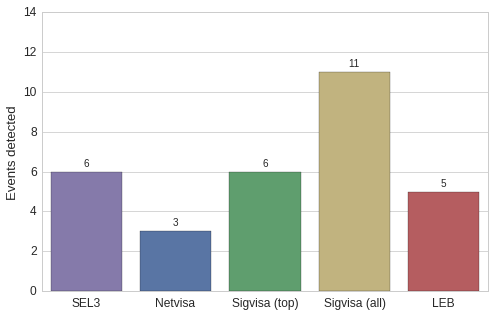

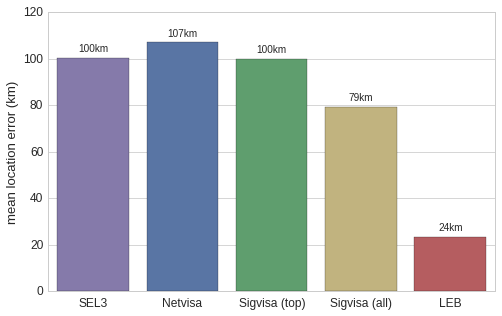

In [43]:
import seaborn as sns
import matplotlib.ticker as mtick

order = ["SEL3", "Netvisa", "Sigvisa (top)", "Sigvisa (all)", "LEB"]
# permute colors to match above precision-recall plot
palette = sns.color_palette()
permuted = (palette[3], palette[0], palette[1], palette[4], palette[2])


sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

fig = plt.figure(figsize=(8, 5))
axes = fig.add_subplot(111)
sns.barplot(x="System", y="Events", data=d, axes=axes, ci=None, 
            order=order, palette=permuted)
axes.set_ylabel("Events detected")
axes.set_xlabel("")

#fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
#yticks = mtick.FormatStrFormatter(fmt)
#axes.yaxis.set_major_formatter(yticks)


# label the plot with error values
rects = axes.patches
#labels = ["%.1f" % recalls[key] for key in order]
labels = ["%d" % nevs[key] for key in order]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axes.text(rect.get_x() + rect.get_width()/2, height + 0.2, label, ha='center', va='bottom')

axes.set_ylim([0, 14])

fig = plt.figure(figsize=(8, 5))
axes = fig.add_subplot(111)
sns.barplot(x="System", y="Error", data=d, axes=axes, ci=None, 
            order=order, palette=permuted)
axes.set_ylabel("mean location error (km)")
axes.set_xlabel("")


# label the plot with error values
rects = axes.patches
labels = ["%.0fkm" % errs[key] for key in order]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axes.text(rect.get_x() + rect.get_width()/2, height + 2, label, ha='center', va='bottom')


In [104]:
# analyze Sigvisa denovo events not in LEB

indices_sv = find_matching(isc_denovo_bulletin, sigvisa_denovo_bulletin, **kwargs)
indices_leb = find_matching(isc_denovo_bulletin, leb_denovo_bulletin, **kwargs)

matched_leb = [i for (i,j) in indices_leb]

s = Sigvisa()

new_sigvisa_orids = []
for (i,j) in indices_sv:
    if i not in matched_leb:
        print isc_denovo_bulletin[i]
        print sigvisa_denovo_bulletin[j]
        print
        isc_orid = isc_denovo_bulletin[i,6]
        orid = s.sql("select orid from sigvisa_origin where matched_isc_orid=%d" % isc_orid)[0][0]
        new_sigvisa_orids.append(orid)
        
print new_sigvisa_orids


[ -1.13916400e+02   3.50155000e+01   7.50000000e+00   1.20060721e+09
   2.90000000e+00   0.00000000e+00   1.04890600e+06]
[ -1.13914428e+02   3.51845690e+01   5.66568192e+00   1.20060722e+09
   3.31066972e+00   1.18500239e+02]

[ -1.19966000e+02   3.93090000e+01   1.26000000e+01   1.20155871e+09
   3.00000000e+00   0.00000000e+00   4.22318000e+05]
[ -1.19214089e+02   3.86024556e+01   2.14905846e+00   1.20155875e+09
   3.30323694e+00   1.39761870e+02]

[ -1.05470000e+02   3.92750000e+01   2.00000000e+00   1.20406895e+09
   2.90000000e+00   0.00000000e+00   1.52368600e+06]
[ -1.04447041e+02   3.90922069e+01   8.14599734e+00   1.20406895e+09
   3.12393330e+00   4.31492330e+01]

[ -1.19979500e+02   3.95228000e+01   1.00000000e+01   1.20497082e+09
   3.40000000e+00   0.00000000e+00   3.90254000e+06]
[ -1.19787347e+02   3.95983371e+01   7.52909315e-01   1.20497082e+09
   2.92590203e+00   2.24634654e+02]

[ -1.20282000e+02   3.95890000e+01   1.41000000e+01   1.20543097e+09
   2.90000000e+00  

# Detection probability by magnitude

In [21]:
# bin isc events by magnitude
# within each magnitude bin, report probability of detection by each other system

import os
from sigvisa.results.compare import f1_and_error, find_matching
import pandas as pd

basedir = "/home/dmoore/python/sigvisa/notebooks/thesis/results/"

#isc_bulletin = np.loadtxt(os.path.join(basedir, "isc_bulletin.txt"))
#netvisa_bulletin = np.loadtxt(os.path.join(basedir, "visa_bulletin_visa.txt"))
#sel3_bulletin = np.loadtxt(os.path.join(basedir, "sel3_bulletin_sel3.txt"))
#leb_bulletin = np.loadtxt(os.path.join(basedir, "leb_bulletin_leb.txt"))
#sigvisa_bulletin_merged = np.loadtxt(os.path.join(basedir, "sigvisa_bulletin_seed123_sum.txt"))
#sigvisa_bulletin_125 = np.asarray([row for row in sigvisa_bulletin_merged if row[5] > 125])



match_delta_deg=2.0
match_delta_s=50.0

truth = isc_wells_mb_bulletin

bulletins = {}
bulletins['Netvisa'] = netvisa_bulletin
bulletins['Sigvisa (top)'] = sigvisa_thresholded 
bulletins['Sigvisa (all)'] = sigvisa_bulletin_merged_123hf
bulletins['SEL3'] = sel3_bulletin
bulletins['LEB'] = leb_bulletin

mb_bins_left = (1.0, 2.0, 2.5, 3.0, 3.5, 4.0,  np.inf)

#scores_by_bin = pd.DataFrame()

def filter_bulletin(bulletin, min_mb, max_mb):
    return 

results = []

for i in range(len(mb_bins_left) - 1):
    min_mb = mb_bins_left[i]
    max_mb = mb_bins_left[i+1]
    
    filter_isc = np.asarray([row for row in truth if row[4] > min_mb and row[4] < max_mb])
    binstr = "%.1f-%.1f" % (min_mb, max_mb) if max_mb < np.inf else "%.1f+" % min_mb
    for key, bulletin in bulletins.items():
        f, p, r, err, errs = f1_and_error(filter_isc, bulletin, 
                                          max_delta_deg=match_delta_deg, 
                                          max_delta_time=match_delta_s)
        results.append((key, binstr, r, int(r/100. * len(filter_isc))))
results = pd.DataFrame(data=results, columns=("Bulletin", "bin", "recall", "evs"))
        

In [22]:

indices_sv = find_matching(filter_isc, bulletins["Sigvisa (all)"], max_delta_deg=match_delta_deg, max_delta_time=match_delta_s)
print indices_sv

[(0, 370), (1, 704), (2, 1285)]


In [23]:
print filter_isc[3]

IndexError: index 3 is out of bounds for axis 0 with size 3

In [24]:
print filter_isc[2]
print bulletins["Sigvisa (all)"][704]

[ -1.14831800e+02   4.11876000e+01   9.18000000e+00   1.20409918e+09
   4.06711821e+00   0.00000000e+00   2.36032000e+05]
[ -1.22770307e+02   3.89291457e+01   6.49511410e+00   1.20383113e+09
   3.79566945e+00   2.34020950e+02]


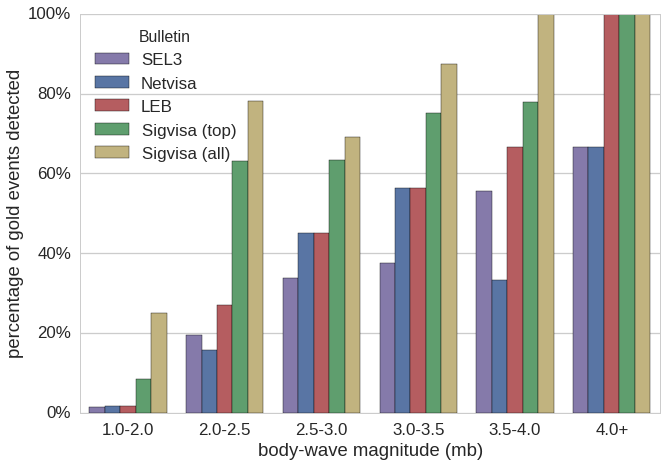

In [25]:
import matplotlib.ticker as mtick


# permute colors to match above precision-recall plot
palette = sns.color_palette()
permuted = (palette[3], palette[0], palette[2], palette[1], palette[4])

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.3)
sns.barplot(x="bin", y="recall", hue="Bulletin", 
            hue_order=["SEL3", "Netvisa", "LEB", "Sigvisa (top)", "Sigvisa (all)"], 
            data=results, palette=permuted)
plt.gca().set_ylabel("percentage of gold events detected")
plt.gca().set_xlabel("body-wave magnitude (mb)")

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(yticks)


In [20]:
print "hello"

hello


In [27]:
min_mb = 3.5
max_mb = 4.0
filter_isc = np.asarray([row for row in truth if row[4] > min_mb and row[4] < max_mb])
print filter_isc

[[ -1.05282500e+02   4.36982000e+01   0.00000000e+00   1.20371802e+09
    3.70000000e+00   0.00000000e+00   3.37543100e+06]
 [ -1.14871300e+02   4.11625000e+01   1.06000000e+01   1.20380956e+09
    3.65201394e+00   0.00000000e+00   2.87968000e+05]
 [ -1.14887700e+02   4.10931000e+01   8.93000000e+00   1.20408718e+09
    3.53341272e+00   0.00000000e+00   2.86414000e+05]
 [ -1.14923700e+02   4.11530000e+01   8.13000000e+00   1.20421144e+09
    3.50799817e+00   0.00000000e+00   2.36336000e+05]
 [ -1.06852400e+02   4.52005000e+01   0.00000000e+00   1.20421834e+09
    3.60000000e+00   0.00000000e+00   3.37607200e+06]
 [ -1.05210700e+02   4.38214000e+01   0.00000000e+00   1.20432836e+09
    3.70000000e+00   0.00000000e+00   3.37619800e+06]
 [ -1.05217000e+02   4.37785000e+01   0.00000000e+00   1.20457110e+09
    3.70000000e+00   0.00000000e+00   3.75261700e+06]
 [ -1.16850700e+02   3.43091000e+01   1.30000000e+01   1.20476247e+09
    3.70000000e+00   0.00000000e+00   3.75299200e+06]
 [ -1.05

# LEB minus Sigvisa

In [26]:
# full sigvisa bulletin
indices = find_matching(leb_bulletin, sigvisa_bulletin_merged_123hf, max_delta_deg=match_delta_deg, max_delta_time=match_delta_s)
leb_evs_matched = [i for (i,j) in indices]
notmatched_bulletin = [leb_bulletin[i] for i in range(len(leb_bulletin)) if i not in leb_evs_matched]

for row in notmatched_bulletin:
    lon, lat, depth, time, mb = row[:5]
    print lon, lat, depth, time, mb

-114.74022 41.035096 0.0 1203703473.0 -999.0
-114.42951 40.860615 0.0 1203748167.0 2.5429521
-114.85047 41.151386 0.0 1203831780.0 -999.0
-114.74279 41.160907 0.0 1204445484.0 -999.0


In [27]:
# full sigvisa bulletin
sigvisa_bulletin_444 = np.asarray([row for row in sigvisa_bulletin_merged_123hf if row[5] > 444])
indices = find_matching(leb_bulletin, sigvisa_bulletin_444, max_delta_deg=match_delta_deg, max_delta_time=match_delta_s)
leb_evs_matched = [i for (i,j) in indices]
notmatched_bulletin = [leb_bulletin[i] for i in range(len(leb_bulletin)) if i not in leb_evs_matched]
for row in notmatched_bulletin:
    lon, lat, depth, time, mb = row[:5]
    print lon, lat, depth, time, mb

-114.92365 41.127744 0.0 1203657221.0 -999.0
-114.87925 40.851762 0.0 1203668114.0 -999.0
-114.96731 41.224394 0.0 1203671772.0 -999.0
-115.25048 41.237505 0.0 1203675783.0 -999.0
-114.74022 41.035096 0.0 1203703473.0 -999.0
-114.69307 40.96367 0.0 1203703564.0 -999.0
-114.97308 41.217925 0.0 1203705968.0 -999.0
-114.98601 41.244917 0.0 1203707613.0 -999.0
-115.04058 41.270541 0.0 1203729452.0 -999.0
-114.42951 40.860615 0.0 1203748167.0 2.5429521
-115.01475 41.241083 0.0 1203748437.0 2.4373969
-114.47897 41.066469 0.0 1203752587.0 -999.0
-114.6916 40.929512 0.0 1203752918.0 -999.0
-114.88003 41.19095 0.0 1203783024.0 -999.0
-114.63588 40.991008 0.0 1203809954.0 -999.0
-115.0 41.174325 0.0 1203828378.0 -999.0
-122.63993 38.850411 0.0 1203831132.0 3.8220426
-114.85047 41.151386 0.0 1203831780.0 -999.0
-114.66059 41.133279 0.0 1203899119.0 -999.0
-114.83112 41.153632 0.0 1203903746.0 -999.0
-114.79676 41.133531 0.0 1203998511.0 -999.0
-114.78928 41.276576 0.0 1204004370.0 -999.0
-114.698

# Maps

ANMO -10 -18 -106.4567 34.9462
ELK -10 -18 -115.2388 40.7448
ILAR -10 -20 -119.548533322 49.0
KDAK -10 -20 -125.029432439 49.0
NEW -10 -18 -117.12 48.26333
NVAR -10 -18 -118.30355 38.429609
PDAR -10 -18 -109.5579 42.7667
PFO -10 -18 -116.4553 33.6092
TXAR -10 -18 -106.266207748 33.0
ULM -20 -18 -100.0 48.5167289879
YBH -10 -18 -122.71038 41.73193
YKA -10 -20 -113.429164961 49.0


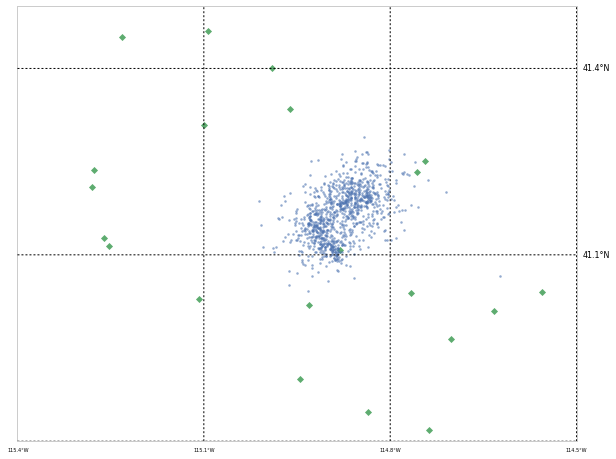

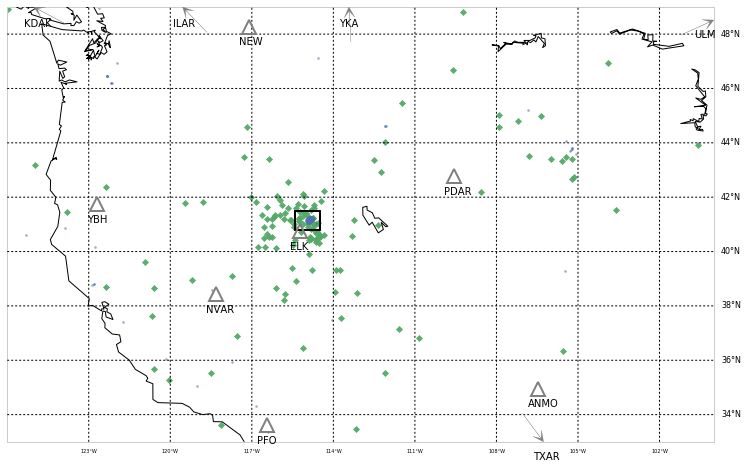

In [21]:
def map_bulletin(bulletin, true_bulletin, preset="full",
                 stas=None, region_args=None, draw_inset=None,
                 **kwargs):

    from sigvisa.plotting.event_heatmap import EventHeatmap

    interval=1
    regions = {"full": {'left_lon': -126, 
                       'right_lon': -100,
                      'bottom_lat': 33, 
                       'top_lat': 49},
                   "wells": {'left_lon': -115.4, 
                       'right_lon': -114.5,
                      'bottom_lat': 40.8, 
                       'top_lat': 41.5},
                   "btm": {'left_lon': -107, 
                       'right_lon': -104,
                      'bottom_lat': 43, 
                       'top_lat': 46} }
    
    region_args = regions[preset]
    
    if preset=="wells":
        stas=None
        interval=0.3
    elif preset=="btm":
        stas=None
        interval=1
    
    s = Sigvisa()
    hm = EventHeatmap(f=None, calc=False, **region_args)

    
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.5)

    
    fig = plt.figure(figsize=(13, 8))
    ax = fig.add_subplot(111)
    hm.init_bmap(axes=ax, nofillcontinents=True, projection="cyl")
    hm.plot_earth(interval=interval)

    if stas is not None:
        sta_locations = [s.earthmodel.site_info(n, 0)[0:2] for n in stas]
        hm.plot_locations(sta_locations, labels=stas, offmap_arrows=True,
                          marker="^", ms=14, mec="gray", mew=2,
                          alpha=1.0, mfc="none", arrow_color="gray", 
                          label_x_off=-10, label_y_off=-18, label_pts=10,)

    scatter_args = {'marker': "D", 's': 25, 'alpha': 0.95, 'c': green, 'lw': 0}
    scatter_args.update(kwargs)
    
    hm.bmap.scatter(bulletin[:, 0], bulletin[:, 1], **scatter_args)
    
    true_bulletin=np.asarray(true_bulletin)
    hm.bmap.scatter(true_bulletin[:, 0], true_bulletin[:, 1], marker=".", s=25, alpha=0.6, c=blue, lw=0)
    
    if draw_inset is not None:
        r = regions[draw_inset]
        hm.drawline((r['left_lon'], r['bottom_lat']), (r['right_lon'], r['bottom_lat']), color='black', lw=2, curve_map=True)
        hm.drawline((r['left_lon'], r['bottom_lat']), (r['left_lon'], r['top_lat']), color='black', lw=2, curve_map=True)
        hm.drawline((r['left_lon'], r['top_lat']), (r['right_lon'], r['top_lat']), color='black', lw=2, curve_map=True)
        hm.drawline((r['right_lon'], r['bottom_lat']), (r['right_lon'], r['top_lat']), color='black', lw=2, curve_map=True)

    
stas = "ANMO,ELK,ILAR,KDAK,NEW,NVAR,PDAR,PFO,TXAR,ULM,YBH,YKA".split(",")

map_bulletin(netvisa_bulletin, truth, stas=stas, preset='wells')
map_bulletin(netvisa_bulletin, truth, stas=stas, draw_inset="wells")



ANMO -10 -18 -106.4567 34.9462
ELK -10 -18 -115.2388 40.7448
ILAR -10 -20 -119.548533322 49.0
KDAK -10 -20 -125.029432439 49.0
NEW -10 -18 -117.12 48.26333
NVAR -10 -18 -118.30355 38.429609
PDAR -10 -18 -109.5579 42.7667
PFO -10 -18 -116.4553 33.6092
TXAR -10 -18 -106.266207748 33.0
ULM -20 -18 -100.0 48.5167289879
YBH -10 -18 -122.71038 41.73193
YKA -10 -20 -113.429164961 49.0


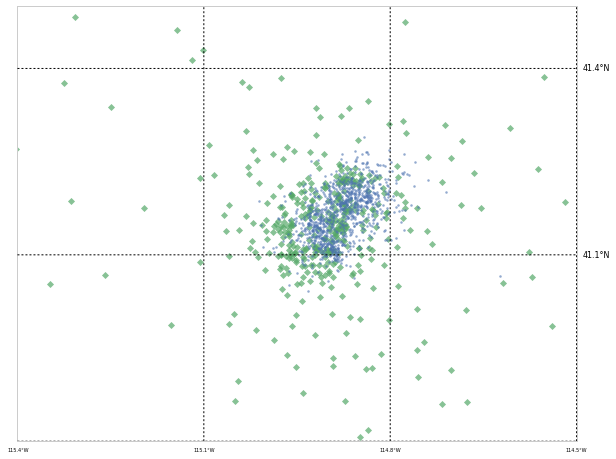

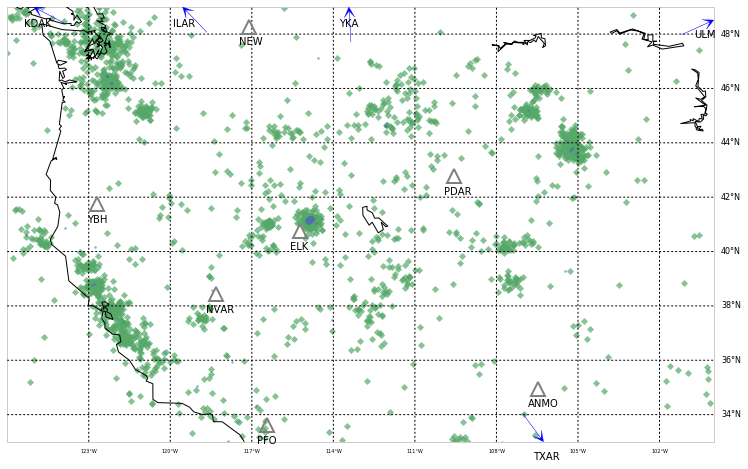

In [16]:
map_bulletin(sigvisa_bulletin_merged_123hf, truth, stas=stas, preset='wells')
map_bulletin(sigvisa_bulletin_merged_123hf, truth, stas=stas)

ANMO -10 -18 -106.4567 34.9462
ELK -10 -18 -115.2388 40.7448
ILAR -10 -20 -119.548533322 49.0
KDAK -10 -20 -125.029432439 49.0
NEW -10 -18 -117.12 48.26333
NVAR -10 -18 -118.30355 38.429609
PDAR -10 -18 -109.5579 42.7667
PFO -10 -18 -116.4553 33.6092
TXAR -10 -18 -106.266207748 33.0
ULM -20 -18 -100.0 48.5167289879
YBH -10 -18 -122.71038 41.73193
YKA -10 -20 -113.429164961 49.0


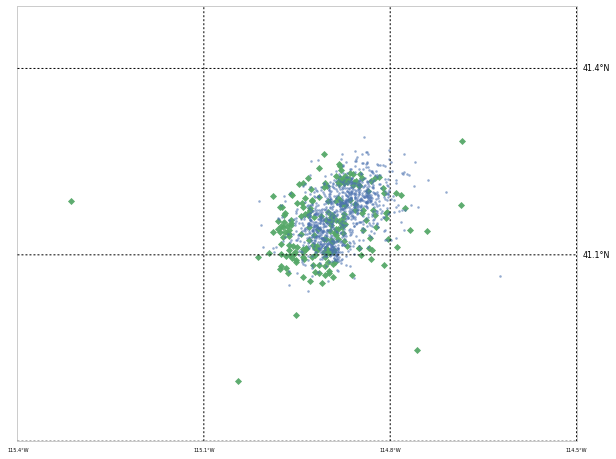

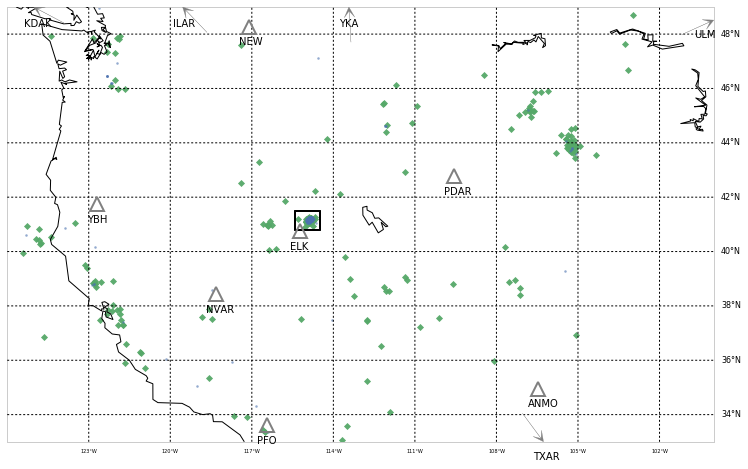

In [22]:
map_bulletin(sigvisa_thresholded, truth, stas=stas, preset="wells")
map_bulletin(sigvisa_thresholded, truth, stas=stas, draw_inset="wells")

ANMO -10 -18 -106.4567 34.9462
ELK -10 -18 -115.2388 40.7448
ILAR -10 -20 -119.548533322 49.0
KDAK -10 -20 -125.029432439 49.0
NEW -10 -18 -117.12 48.26333
NVAR -10 -18 -118.30355 38.429609
PDAR -10 -18 -109.5579 42.7667
PFO -10 -18 -116.4553 33.6092
TXAR -10 -18 -106.266207748 33.0
ULM -20 -18 -100.0 48.5167289879
YBH -10 -18 -122.71038 41.73193
YKA -10 -20 -113.429164961 49.0


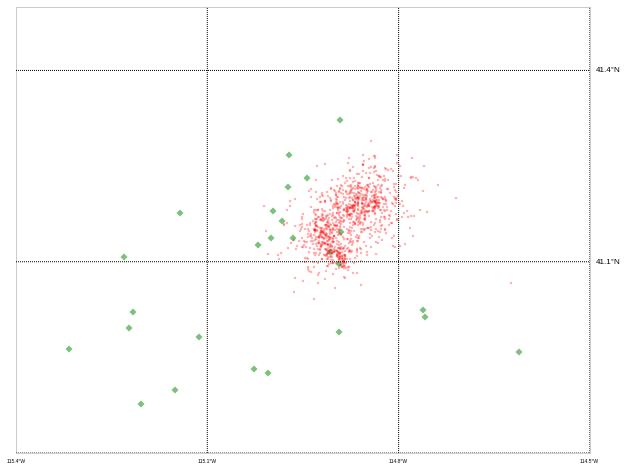

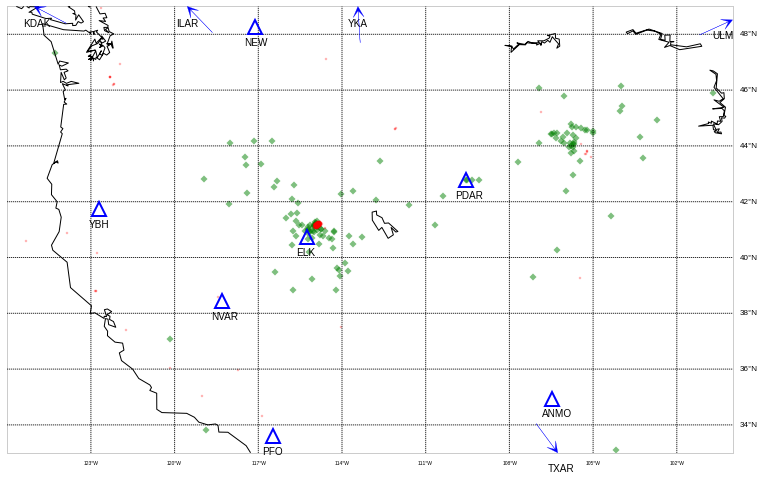

In [93]:
map_bulletin(sel3_bulletin, truth, stas=stas, preset="wells")
map_bulletin(sel3_bulletin, truth, stas=stas)

ANMO -10 -18 -106.4567 34.9462
ELK -10 -18 -115.2388 40.7448
ILAR -10 -20 -119.548533322 49.0
KDAK -10 -20 -125.029432439 49.0
NEW -10 -18 -117.12 48.26333
NVAR -10 -18 -118.30355 38.429609
PDAR -10 -18 -109.5579 42.7667
PFO -10 -18 -116.4553 33.6092
TXAR -10 -18 -106.266207748 33.0
ULM -20 -18 -100.0 48.5167289879
YBH -10 -18 -122.71038 41.73193
YKA -10 -20 -113.429164961 49.0


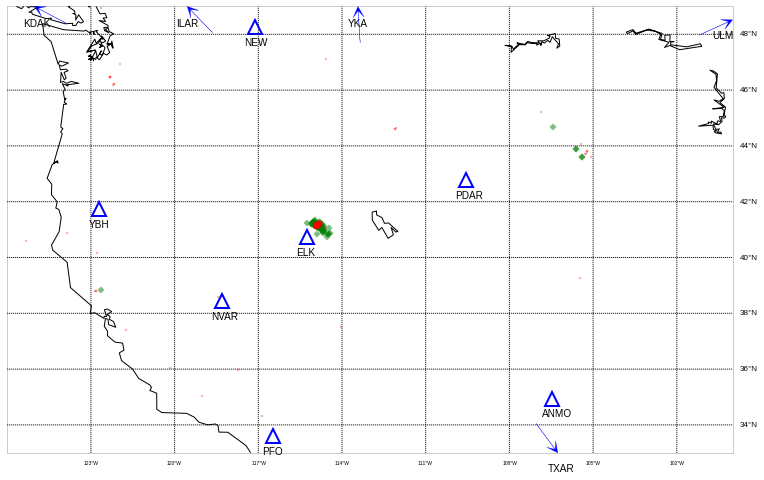

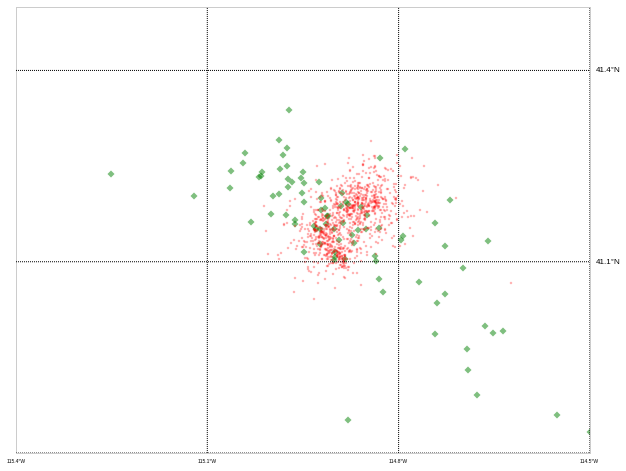

In [94]:
map_bulletin(leb_bulletin, truth, stas=stas)
map_bulletin(leb_bulletin, truth, stas=stas, preset="wells")

In [100]:
# does sigvisa detect any denovo events *not* already in the ISC?
filter_de_novo(isc_wells_analyst_bulletin)

# turns out (from manual examination) the answer is no: the top five of these events are not in ISC, but all look false.

array([[ -1.13689761e+02,   3.30482980e+01,   1.07700320e+01,
          1.20370869e+09,   6.09689000e+00,   6.17706153e+02,
         -1.00000000e+00],
       [ -1.10106961e+02,   3.75471390e+01,   2.23307700e+00,
          1.20373742e+09,   2.84251000e+00,   2.31894869e+02,
         -1.00000000e+00],
       [ -1.10799249e+02,   3.72269130e+01,   2.17708950e+01,
          1.20378328e+09,   5.00300900e+00,   3.83852372e+02,
         -1.00000000e+00],
       [ -1.03257896e+02,   4.76513250e+01,   7.57995000e-01,
          1.20378329e+09,   5.33771700e+00,   2.03902747e+02,
         -1.00000000e+00],
       [ -1.17391107e+02,   4.25088710e+01,   6.91717200e+00,
          1.20397442e+09,   4.45683700e+00,   1.65846999e+02,
         -1.00000000e+00],
       [ -1.05470000e+02,   3.92750000e+01,   2.00000000e+00,
          1.20406895e+09,   2.90000000e+00,   0.00000000e+00,
          1.52368600e+06],
       [ -1.14578200e+02,   4.71096000e+01,   1.00000000e+01,
          1.20437136e+09,   2.80

# De novo event not in LEB

In [146]:
from sigvisa.source.event import Event
from sigvisa.infer.coarse_to_fine_init import EventRunSpec, ModelSpec, initialize_sg
#http://kampos.banatao.berkeley.edu:8001/sigvisa/bulletin/2279/signals.html
   
ev = Event(lon=-119.79, lat=39.60, depth=0.8, time=1204970823.4, mb=2.9)

hz=10
stas = "ANMO,ELK,ILAR,KDAK,NEW,NVAR,PDAR,PFO,TXAR,ULM,YBH,YKA".split(",")
phases = "P,Pn,Pg,Lg,Sn".split(',')
runid=25
band="freq_0.8_4.5"

rs = EventRunSpec(evs=[ev,], stas=stas,
                  initialize_events=True,
                  pre_s=20, post_s=60,
                  disable_conflict_checking=True)
ms1 = ModelSpec(template_model_type="param",
        wiggle_family="iid",
        wiggle_model_type="dummy",
        uatemplate_rate=1e-3,
        max_hz=hz,
        phases=phases,
        bands=(band,),
        runids=(runid,),
        min_mb=1.0,
        skip_levels=0,
        dummy_fallback=True,
        raw_signals=True,
        hack_param_constraint=True,
        vert_only=True)
sg = rs.build_sg(ms1)
initialize_sg(sg, ms1, rs)

for n in sg.extended_evnodes[1]:
    if n in sg.evnodes[1].values(): continue
    if n.deterministic(): continue
    n.parent_predict()



warning, no hparam prior specified for mult_wiggle_std , using dummy
sg
missing waveform Can't find data for sta TXAR chan SHZ time 1204971019
waves
added waves


reading station detections... 
reading station detections... 
reading station detections... 


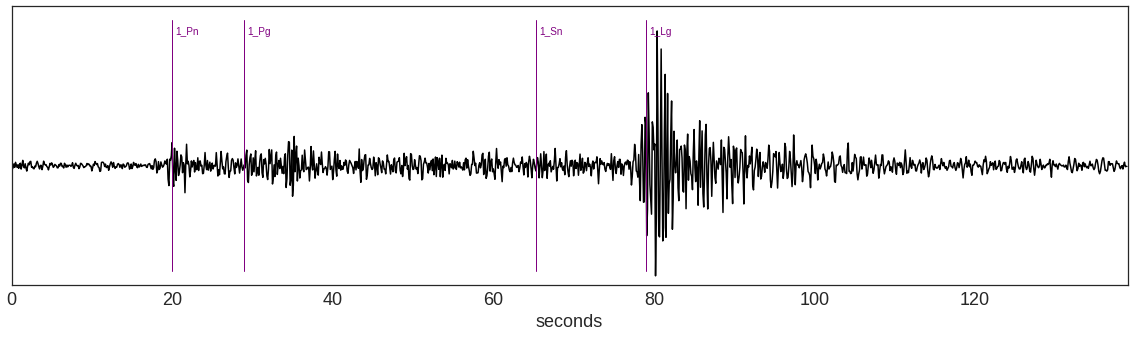

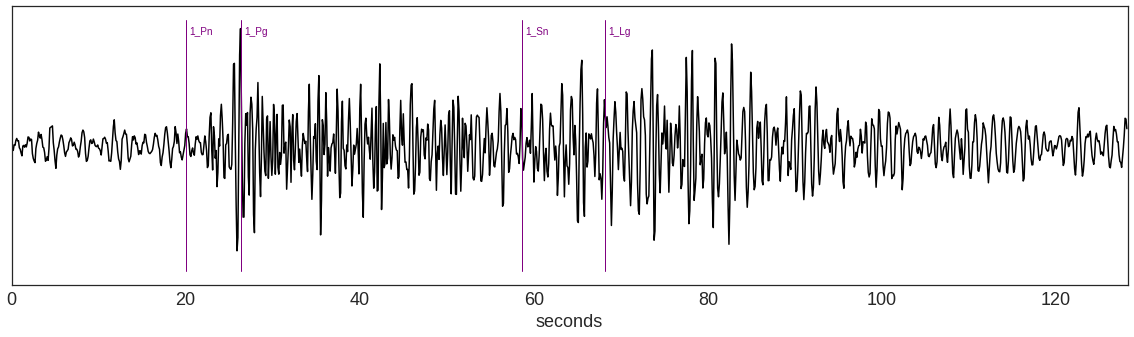

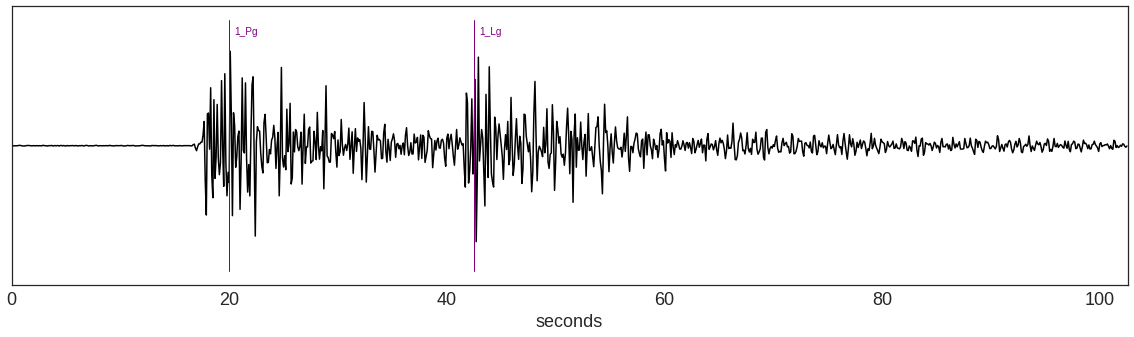

In [148]:


def plot_sta(sta):
    try:
        wn = sg.station_waves[sta][0]
    except IndexError:
        s = Sigvisa()
        sta = s.get_default_sta(sta)
        wn = sg.station_waves[sta][0]


    f = plt.figure(figsize=(20, 5))
    ax = f.add_subplot(111)
    sns.set_style("white")
    sns.set_context("paper", font_scale=1.0)

    atime_args = {"color": "purple",
                  "top_rel": 0.95,
                  "bottom_rel": 0.05}
    wn.plot(ax=ax, model_lw=None, unass_lw=None, ev_lw=None, atime_args=atime_args)

    # clean up axes
    stime = wn.st+20
    etime = wn.et-20
    ax.set_xlim([stime, etime])

    tick_interval = 20
    nticks = np.floor((etime-stime)/tick_interval)
    ticks_base = np.arange(nticks+1) * tick_interval 
    ax.set_xticks(ticks_base + stime)
    labels = ["%d" % tick for tick in ticks_base]
    ax.set_xticklabels(labels, fontsize=18)
    #ax.set_xlabel("seconds")
    ax.set_yticks([])

    plt.xlabel('seconds', fontsize=18)
    plt.ylabel('', fontsize=18)

plot_sta("ELK")
plot_sta("YBH")
plot_sta("NVAR")


In [7]:
blue, green, red, purple = sns.color_palette()[:4]

print np.asarray(blue)*255
print np.asarray(green)*255
print np.asarray(red)*255
print np.asarray(purple)*255

[  76.  114.  176.]
[  85.  168.  104.]
[ 196.   78.   82.]
[ 129.  114.  178.]
